<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import ipyparallel as ipp
from mpi4py import MPI

In [ ]:
# use on command line:
# ipcluster start -n 6 --profile=mpi

In [118]:
cluster = ipp.Client(profile='mpi')
print('profile:', cluster.profile)
print("IDs:", cluster.ids) # Print process id numbers
%px import numpy as np

profile: mpi
IDs: [0, 1, 2, 3, 4, 5]


In [4]:
%%px

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# passing MPI datatypes explicitly
if rank == 0:
    data = np.arange(100, dtype='i')
    np.random.shuffle(data)
    comm.Send([data, MPI.INT], dest=1, tag=77)
    print("{} of {}: sent data to 1: {}".format(rank, size, data))
elif rank == 1:
    data = np.empty(100, dtype='i')
    comm.Recv([data, MPI.INT], source=0, tag=77)
    print("{} of {}: received data from 0: {}".format(rank, size, data))
else:
    print("{}: idle".format(rank))

[stdout:0] 
0 of 6: sent data to 1: [92 35 82 84 79 17 95 30 69 66 16 75 36 48 52 27 73 26 77  4  7 99 94 57
 70 10 87 83 45 71 58 23 61  0 90  1 49 74 54 62 41 76 14 21 89  2 42 15
 64 80  6 88 38 97 33 19 59 11 18 65 98  5  8 39 28 50 13 20 53 43 72 63
 12 32 56 24 78 93 86 22 44 85 81 25 68 51  3 96 40  9 55 31 60 47 29 91
 37 46 34 67]
[stdout:1] 
1 of 6: received data from 0: [92 35 82 84 79 17 95 30 69 66 16 75 36 48 52 27 73 26 77  4  7 99 94 57
 70 10 87 83 45 71 58 23 61  0 90  1 49 74 54 62 41 76 14 21 89  2 42 15
 64 80  6 88 38 97 33 19 59 11 18 65 98  5  8 39 28 50 13 20 53 43 72 63
 12 32 56 24 78 93 86 22 44 85 81 25 68 51  3 96 40  9 55 31 60 47 29 91
 37 46 34 67]
[stdout:2] 2: idle
[stdout:3] 3: idle
[stdout:4] 4: idle
[stdout:5] 5: idle


In [ ]:
from cubedspherepartitioner import CubedSpherePartitioner

In [ ]:
CubedSpherePartitioner

In [20]:
import numpy as np
import math

In [21]:
cube_neighbors = {1: {'U': [3, 3], 'D': [6, 0], 'L': [5, 1], 'R': [2, 0]},
                  2: {'U': [3, 0], 'D': [6, 3], 'L': [1, 0], 'R': [4, 1]},
                  3: {'U': [5, 3], 'D': [2, 0], 'L': [1, 1], 'R': [4, 0]},
                  4: {'U': [5, 0], 'D': [2, 3], 'L': [3, 0], 'R': [6, 1]},
                  5: {'U': [1, 3], 'D': [4, 0], 'L': [3, 1], 'R': [6, 0]},
                  6: {'U': [1, 0], 'D': [4, 3], 'L': [5, 0], 'R': [2, 1]}}

In [25]:
size = 24
ranks_per_tile = size // 6
my_tile = size // ranks_per_tile
ranks_per_axis = int(math.sqrt(ranks_per_tile))


In [3]:
tiles_placement = {i: (i // ranks_per_tile) + 1 for i in range(size)}

In [4]:
tiles_placement.items()

dict_items([(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 2), (6, 2), (7, 2), (8, 3), (9, 3), (10, 3), (11, 3), (12, 4), (13, 4), (14, 4), (15, 4), (16, 5), (17, 5), (18, 5), (19, 5), (20, 6), (21, 6), (22, 6), (23, 6)])

In [7]:
ranks_placement = dict()
for k, v in tiles_placement.items():
    ranks_placement.setdefault(v, list()).append(k)

In [8]:
ranks_placement

{1: [0, 1, 2, 3],
 2: [4, 5, 6, 7],
 3: [8, 9, 10, 11],
 4: [12, 13, 14, 15],
 5: [16, 17, 18, 19],
 6: [20, 21, 22, 23]}

In [9]:
tile_roots = {v: k[0] for v, k in ranks_placement.items()}

In [10]:
tile_roots

{1: 0, 2: 4, 3: 8, 4: 12, 5: 16, 6: 20}

In [11]:
assert cube_neighbors[1]['L'][0] == cube_neighbors[6]['L'][0] == cube_neighbors[4]['U'][0], 'Cube geometry faulty'
assert cube_neighbors[6]['D'][0] == cube_neighbors[2]['R'][0] == cube_neighbors[3]['R'][0], 'Cube geometry faulty' 
assert cube_neighbors[3]['U'][0] == cube_neighbors[6]['L'][0] == cube_neighbors[1]['L'][0], 'Cube geometry faulty'

In [12]:
for i in range(6):
    rotation_sum = 0
    [rotation_sum := rotation_sum + k[1] for v, k in cube_neighbors[i+1].items()]
    assert rotation_sum == 4, 'Cube geometry faulty' 


In [35]:
rank_grid = np.asarray([np.asarray(ranks_placement[i+1]).reshape(ranks_per_axis, -1) for i in range(6)])


In [41]:
[[j for j in i.ravel()] for i in rank_grid]

[[0, 1, 2, 3],
 [4, 5, 6, 7],
 [8, 9, 10, 11],
 [12, 13, 14, 15],
 [16, 17, 18, 19],
 [20, 21, 22, 23]]

In [34]:
test[0]

array([[0, 1],
       [2, 3]])

In [178]:
m = np.array([[5, 0],
              [0, 5]])

In [179]:
np.rot90(m, 0)

array([[5, 0],
       [0, 5]])

In [181]:
np.rot90(m, -1)

array([[0, 5],
       [5, 0]])

In [139]:
np.rot90(m, 3)

array([[0, 1],
       [0, 0]])

In [140]:
x =  np.array([[1],[0]])

In [141]:
x

array([[1],
       [0]])

In [145]:
np.rot90(x, 3)

array([[0, 1]])

In [209]:
import matplotlib.pyplot as plt
%matplotlib inline

(-1.0, 2.0)

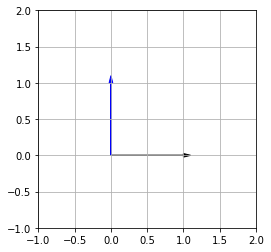

In [237]:

X = np.array((0))
Y = np.array((0))
E= np.array([[1, 0],
             [0, 1]])


fig, ax = plt.subplots()
q1 = ax.arrow(X, Y, E[0, 0], E[1, 0], head_width=0.05, head_length=0.1, fc='k', ec='k')
q2 = ax.arrow(X, Y, E[0, 1], E[1, 1], head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.grid()
ax.set_aspect('equal')

plt.xlim(-1,2)
plt.ylim(-1,2)

[[1 0]
 [0 1]]
[[ 0  1]
 [-1  0]]
[[-1  0]
 [ 0 -1]]
[[ 0 -1]
 [ 1  0]]


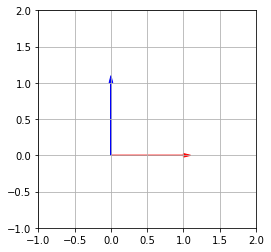

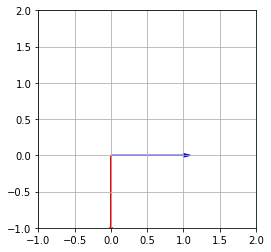

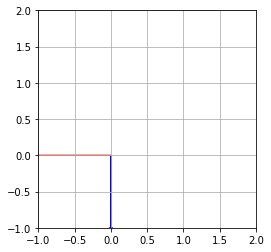

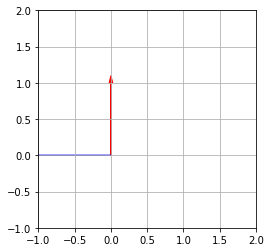

In [240]:
for i in range(4):
    E= np.array([[1, 0],
                 [0, 1]])
    E = np.matmul(rotate_90_deg[i], E)        
    print(E)
    fig, ax = plt.subplots()
    q1 = ax.arrow(X, Y, E[0, 0], E[1, 0], head_width=0.05, head_length=0.1, fc='r', ec='r')
    q2 = ax.arrow(X, Y, E[0, 1], E[1, 1], head_width=0.05, head_length=0.1, fc='b', ec='b')
    plt.grid()
    ax.set_aspect('equal')

    plt.xlim(-1,2)
    plt.ylim(-1,2)

In [223]:
rot_L = np.array([[0,-1],
                  [1, 0]])

In [227]:
rot_R = np.array([[ 0, 1],
                  [-1, 0]])

In [44]:
rotate_90_deg = np.asarray([ [[ 1, 0],
                        [ 0, 1]],
                       [[ 0, 1],
                        [-1, 0]],
                       [[-1, 0],
                        [ 0,-1]],
                       [[ 0,-1],
                        [ 1, 0]] ])

In [45]:
rotate_90_deg[1]

array([[ 0,  1],
       [-1,  0]])

In [49]:
def setup_grid(__num_ranks):

    for ranks_x in range(math.floor( math.sqrt(__num_ranks) ), 0, -1):
        if __num_ranks % ranks_x == 0:
            break
    __size = (__num_ranks // ranks_x, ranks_x)
    return __size

In [52]:
setup_grid()

(6, 3)

In [59]:
a,\
b,\
c = func1()

In [55]:
def func1():
    return 1,2,3

In [57]:
func1()

(1, 2, 3)

In [60]:
ranks_per_tile

4

In [61]:
18 % 4

2

In [62]:
16 % 4

0

In [43]:
assert math.sqrt(25 / 6).is_integer(), \
            "Number of ranks per face must be square number"

AssertionError: Number of ranks per face must be square number